In [1]:
## Goal
## Create sample segmentations, with paired labels from labels
## Generates individual point clouds and label, with similar filenames (.npt, txt) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
## SCAN DATASET GENERATION

def generate_sample_labels(n_labels=10, n_welds_options=np.array([2, 3, 4, 5, 6] ), scan_width=120, scan_height=40):
    
    ## Generating Labels with some randomness
    labels = []
    for _ in range(n_labels):
        weld_list = []
        
        ## number of welds for label and sectioning the horizontal(x-axis) range into welds
        n_w = np.random.choice(n_welds_options)
        centers = (np.arange(n_w)+0.5)/n_w

        ## adding y_axis to each weld
        centers = np.expand_dims(centers, axis=1)
        centers = np.hstack([centers, np.ones_like(centers)*0.5])

        ## adding randomness to each weld position
        center_shifts = 0.1*np.random.rand(n_w, 2)/n_w
        centers+=center_shifts

        ## randomly dropping some welds
        dropouts = np.random.choice([0,1], n_w, p=np.array([0.1, 0.9]))
        centers[:, 0]*=dropouts
        centers = centers[centers[:, 0]!=0]

        ## scaling welds to scan footprint
        centers*=np.array([scan_width, scan_height])
        for weld in centers:
            weld_list.append((weld[0], weld[1]))
            
        labels.append(weld_list)
#         print(f'{n_w} --> {weld_list}')
        
    return labels

def generate_mock_scan_from_label(label, weld_h=30, weld_w=15, plot_aggregate=False):
    """
    label ==> a list of tuples, each representing the weld center
    """
    
    points_x_y_id = []
    colors = ['y', 'r', 'm', 'b', 'g', 'k', 'c']
    print()
    for idx, weld_loc in enumerate(label):
        print(weld_loc)
        x, y = weld_loc
        label_id = idx
        nx, ny = weld_w, weld_h
        
        ## meshgrid + random offset
        xs = np.linspace(-weld_w/2, weld_w/2, nx) + x 
        ys = np.linspace(-weld_h/2, weld_h/2, ny) + y
        xv, yv = np.meshgrid(xs, ys)
        xy = np.vstack([xv.flatten(), yv.flatten()]).T
        xy_shift = np.random.rand(xy.shape[0], xy.shape[1])*np.array([weld_w/nx, weld_h/ny])-np.array([weld_w/nx/2, weld_h/ny/2]) 
        xy += xy_shift

        ## dropping some points out
        dropouts = np.random.choice([0,1], xy.shape[0], p=np.array([0.4, 0.6]))
        dropouts = np.vstack([dropouts, dropouts]).T
        xy *= dropouts
        xy = xy[np.all(xy != 0, axis=1)]
        
        ## including the instance id
        xy = np.hstack([xy, np.ones((xy.shape[0], 1))*label_id])
        
        ## collating and plotting together
        points_x_y_id.append(xy)
        if plot_aggregate:
            plt.plot(xy[:,0], xy[:,1], marker='o', color=colors[label_id], linestyle='none')
    
    
    points = np.vstack(points_x_y_id)
    if plot_aggregate:
        plt.show()
    return points



In [4]:
## WELD DATASET GENERATION

def extract_welds_from_cleaned_segmentation(points_xyinst, threshold_wrt_avg=0.75):
## will need to check if the points come through with the z locations and if the inst col was identified and parsed correctly
    welds=[]
    
    ## looking at the inst col for grouping
    points_inst = points_xyinst[:, -1]
    
    ## check that grouping meets a size criterion
    insts, counts = np.unique(points_inst, return_counts=True)
    threshold = np.mean(counts)*threshold_wrt_avg

    ## collect groupings into a list of xy points
    for inst in insts:
        weld_xy = points_xyinst[points_inst==inst, :2]
        if weld_xy.shape[0] >= threshold:
            welds.append(weld_xy)
        
    return welds

# welds = extract_welds_from_cleaned_segmentation(pts_xyinst)

def match_welds_and_centers(welds, centers):
    pairings = []
    
    ## looping through each grouping of points
    for idx, weld in enumerate(welds):
        
        ## checking grouping for the limits in x
        ## labels for if within limits in x
        xmin = np.min(weld[:, 0])
        xmax = np.max(weld[:, 0])
        center = []
        
        for x,y in centers:
            if xmin<=x<=xmax:
                center.append((x,y))
        
        ## pairing points and location label
        pairings.append({"points_xy": weld, "xy":center})
        
    return pairings

# welds_and_labels = match_welds_and_centers(welds, labels[-1])
# print(welds_and_labels)

def create_weld_and_label_files(points_xyinst, centers, filename_prefix="", directory="./dataset/"):
    if not os.path.isdir(directory):
        os.mkdir(directory)
        print(f"created: {directory}")
        
    weld_scan_path = f"{directory}weld_scan/"
    if not os.path.isdir(weld_scan_path):
        os.mkdir(weld_scan_path)
        print(f"created: {weld_scan_path}")
        
    weld_label_path = f"{directory}weld_label/"
    if not os.path.isdir(weld_label_path):
        os.mkdir(weld_label_path)
        print(f"created: {weld_label_path}")
        
    last_file_tag = 0
    scan_filenames = os.listdir(weld_scan_path)
    scan_filenames = [file.split(".")[0] for file in scan_filenames]
    scan_suffixes = [file.split("_")[-1] for file in scan_filenames if file.startswith(filename_prefix)]
    
    if len(scan_suffixes) > 0:
        scan_suffixes = [int(suffix) for suffix in scan_suffixes]
        last_file_tag = max(scan_suffixes)
        print("last_file_tag")
        print(last_file_tag)
     
    welds = extract_welds_from_cleaned_segmentation(points_xyinst)
    welds_and_labels = match_welds_and_centers(welds, centers)
    for w_l in welds_and_labels:
        last_file_tag+=1
        np.save(f"{weld_scan_path}{filename_prefix}{last_file_tag}", w_l["points_xy"])
        np.savetxt(f"{weld_label_path}{filename_prefix}{last_file_tag}.txt", np.array(w_l["xy"]),"%1.4f" )
        print(f"created scan: {weld_scan_path}{filename_prefix}{last_file_tag}")
        print(f"created label: {weld_label_path}{filename_prefix}{last_file_tag}")
        

# create_weld_and_label_files(pts_xyinst, labels[-1], filename_prefix="abc_")

In [5]:
# labels


(36.83826802620199, 20.55854830003323)
(62.33211664144537, 20.74704403429701)
(84.78853618915204, 20.00299152754236)
(108.43343480921678, 20.022202144854187)


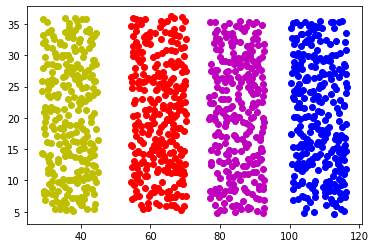


(34.114460451898104, 20.8298499215501)


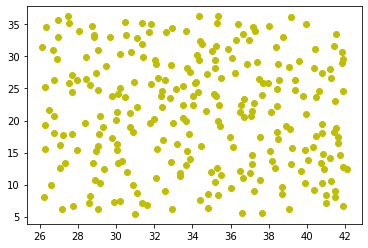


(13.9116269660547, 20.190054673519285)
(36.39985617563652, 20.56062754647302)
(61.31407310894748, 20.780501783795337)
(84.49925080185658, 20.562412622817842)
(110.01321158323934, 20.15350230122116)


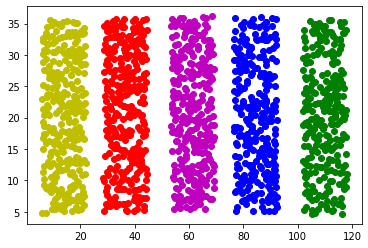


(35.13308962169021, 20.62199700908546)
(90.33811352783047, 20.3101460867406)


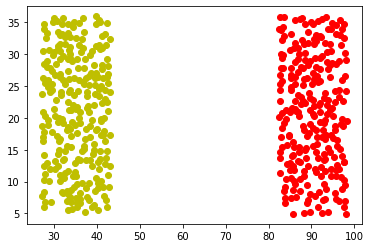


(21.301524266354743, 21.14760151111083)
(63.15571605067467, 20.40670194515681)
(100.6525921959901, 20.396495529804362)


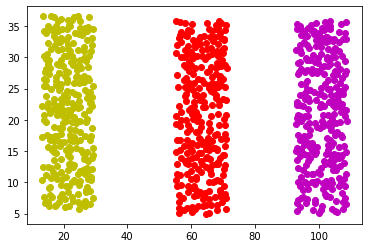


(14.369333851509225, 20.366381284406245)
(38.178315582223995, 20.713520828231573)
(84.45738892543513, 20.782428867699807)
(108.71663577543312, 20.167171505923132)


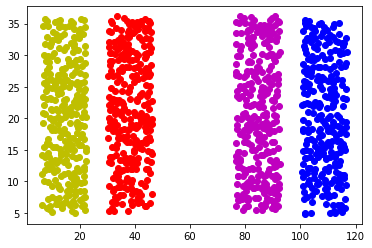


(34.39188941676544, 21.80678419615143)
(92.72405090739319, 21.85742574000239)


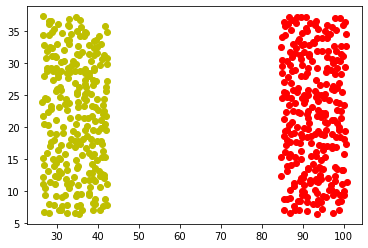


(30.140745373017918, 21.78704127065338)
(93.99501364271732, 20.360534789814558)


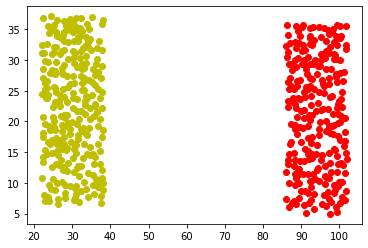


(22.129913904572287, 20.494090383411404)
(62.53815316515873, 20.91995067420289)
(100.50800319442827, 20.911138770236004)


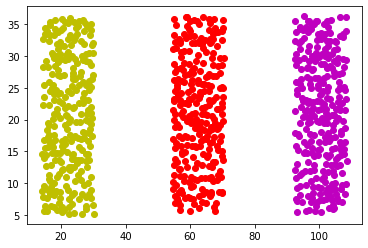


(46.61481431658152, 20.45067392279707)
(77.7866346729745, 20.51067254821191)
(106.55214402279884, 20.07792581163706)


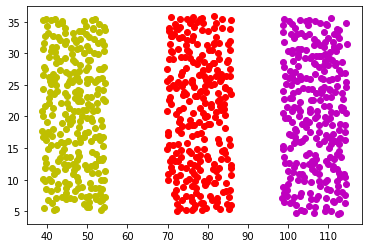

last_file_tag
2
created scan: ./dataset/weld_scan/abc_3
created label: ./dataset/weld_label/abc_3
created scan: ./dataset/weld_scan/abc_4
created label: ./dataset/weld_label/abc_4
created scan: ./dataset/weld_scan/abc_5
created label: ./dataset/weld_label/abc_5
created scan: ./dataset/weld_scan/abc_6
created label: ./dataset/weld_label/abc_6
last_file_tag
6
created scan: ./dataset/weld_scan/abc_7
created label: ./dataset/weld_label/abc_7
last_file_tag
7
created scan: ./dataset/weld_scan/abc_8
created label: ./dataset/weld_label/abc_8
created scan: ./dataset/weld_scan/abc_9
created label: ./dataset/weld_label/abc_9
created scan: ./dataset/weld_scan/abc_10
created label: ./dataset/weld_label/abc_10
created scan: ./dataset/weld_scan/abc_11
created label: ./dataset/weld_label/abc_11
created scan: ./dataset/weld_scan/abc_12
created label: ./dataset/weld_label/abc_12
last_file_tag
12
created scan: ./dataset/weld_scan/abc_13
created label: ./dataset/weld_label/abc_13
created scan: ./dataset/w

In [6]:
## Generating Labels    
labels = generate_sample_labels()
scans = []
for label in labels:
    pts_xyinst = generate_mock_scan_from_label(label, plot_aggregate=False)
    scans.append(pts_xyinst)
    
for scan, label in zip(scans, labels):
    create_weld_and_label_files(scan, label, filename_prefix="abc_")
    

In [7]:
# TOMORROW

## Add the data
## THEN EXPAND pcloader to include npt
## Add Weld and weld label parser to visualizer to verify each of the 300*scan set

## Implement the new gnn Network  

In [1]:
"file".split("_")

['file']